# Ringtrial

> Evaluation Resnet 18 pre-trained on OSSL dataset on ringtrial data.


In [ ]:
# Todo:
#   - generate transformed OSSL dataset from 650-4000
#   - retrained model on OSSL dataset using this wavenumber range
#   - generate transformed ringtrial dataset
#   - generate transformed Fukushima dataset

## Runpod setup

In [ ]:
# setting up pod and pip install uhina
# accessing a pod terminal

# 1. To get access to the pod ip adress: runpodctl get pod -a
# 2. ssh into the pod: ssh root@<ip-address> -p 58871 -i ~/.ssh/id_ed25519

# git clone https://github.com/franckalbinet/uhina.git
# pip install uhina
# runpodctl send im-bw 
# runpodctl send ossl-tfm.csv


## Loading data

In [ ]:
import pandas as pd
from pathlib import Path
import fastcore.all as fc

from fastai.data.all import *
from fastai.vision.all import *
from multiprocessing import cpu_count

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ossl_source = '../../_data/ossl-tfm/ossl-tfm.csv'
df = pd.read_csv(ossl_source); df.head()

,fname,kex
0,3998362dd2659e2252cd7f38b43c9b1f.png,0.182895
1,2bab4dbbac073b8648475ad50d40eb95.png,0.082741
2,29213d2193232be8867d85dec463ec00.png,0.089915
3,8b1ee9146c026faee20a40df86736864.png,0.135030
4,6e8e9d1105e7da7055555cb5d310df5f.png,0.270421


In [ ]:
df['kex'].min(), df['kex'].max() 

(0.0, 3.6521352871126975)

In [ ]:
# image size is 750x281

In [ ]:
# start = np.random.uniform(1, 50); print(start)
# end = np.random.uniform(90.1, 99.5); print(end)
# steps = np.random.randint(5, 100); print(steps)
# percentiles = torch.linspace(start=start, end=end, steps=steps)
# percentiles

In [ ]:
@delegates()
class Quantize(RandTransform):
    # split_idx,mode,mode_mask,order = None,BILINEAR,NEAREST,1
    "Quantize B&W image into `num_colors` colors."
    split_idx = None
    def __init__(self, 
        num_colors:int=10,
        verbose:bool=False,
        n_percentiles_valid:int=100, # how many different quantization to generate for valid set
        seed:int|None=41, # Seed for random number generator used to generate fixed augmentation for validation set
        **kwargs
    ):
        store_attr()
        super().__init__(**kwargs)
        self.counter_valid = 0
        self.percentiles = None
        self.percentiles_valid = self.generate_percentiles_valid(n=n_percentiles_valid, seed=self.seed)

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset (0: train, 1: valid)
    ):
        self.idx = split_idx
        
    def get_random_percentiles(self, seed:int|None=None):
        if seed is not None:
            np.random.seed(seed)
        start = np.random.uniform(1, 50)
        
        end = np.random.uniform(90.1, 99.5)
        steps = np.random.randint(5, 100)
        return torch.linspace(start=start, end=end, steps=steps)

    def generate_percentiles_valid(self, n:int=100, seed:int|None=None):
        return [self.get_random_percentiles(seed=self.seed) for i in range(n)]
    
    def get_percentiles(self):
        if self.idx == 1:
            return self.percentiles_valid[self.counter_valid%len(self.percentiles_valid)]
        else:
            return self.get_random_percentiles()
    
    def encodes(self, x:Image.Image):
        im_tensor = image2tensor(x)[0, :, :]
        
        percentiles = self.get_percentiles()
        levels = torch.quantile(im_tensor.float(), percentiles / 100)
        im_quant = torch.bucketize(im_tensor.float(), levels)
        
        cmap = plt.get_cmap('Spectral_r')
        im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
        im_color = im_color.permute(2, 0, 1)
        return to_image(im_color)

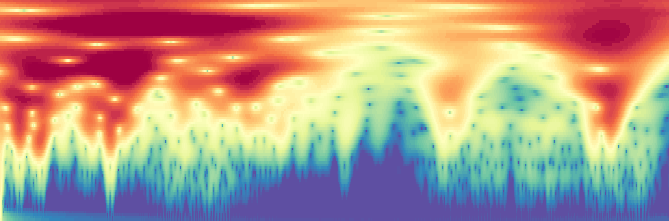

In [ ]:
      
# Image.Image
im_path = '../../_data/all-grey-255.png'
im = PILImage.create(im_path)
# type(im)
# im = Image.open(im_path)
# PILImageBW
# fastai_im = PILImageBW(im_path) # fastai.vision.core.PILImage
# fastai_im.show(figsize=(10,10))

im = Quantize(verbose=False)(im)
im


original shape: (221, 669)
tensor shape: torch.Size([3, 221, 669]) which is simply each pixel value replicated 3 times (R, G, B)
tensor shape: torch.Size([221, 669])
percentiles: tensor([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
        68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
        82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
        96., 97., 98.])
levels: tensor([182., 183., 185., 187., 189., 191., 192., 194., 195., 198., 200., 202.,
        204., 206., 207., 209., 210., 211., 213., 214., 215., 216., 217., 218.,
        219., 220., 220., 221., 222., 223., 224., 225., 226., 227., 229., 230.,
        231., 232., 232., 233., 234., 235., 236., 237., 238., 238., 239., 240.,
        240., 241., 241., 242., 243., 243., 243., 245., 246., 248., 250.])
im_quant: tensor([[41, 41, 41,  ..., 46, 46, 46],
        [41, 41, 41,  ..., 46, 4

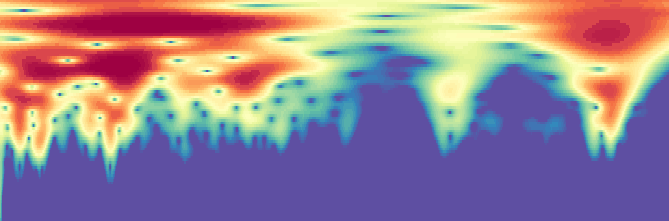

In [ ]:
im_path = '../../_data/all-grey-255.png'
im = PILImage.create(im_path)
print(f'original shape: {im.shape}')

im_tensor = image2tensor(im)
print(f'tensor shape: {im_tensor.shape} which is simply each pixel value replicated 3 times (R, G, B)')

im_tensor = im_tensor[0, :, :]
print(f'tensor shape: {im_tensor.shape}')

percentiles = torch.arange(40, 99, 1, dtype=torch.float32)
print(f'percentiles: {percentiles}')

levels = torch.quantile(im_tensor.float(), percentiles / 100)
print(f'levels: {levels}')

im_quant = torch.bucketize(im_tensor.float(), levels)
print(f'im_quant: {im_quant}, # unique values: {im_quant.unique()}')

# Color map: takes values between 0 and 1 and returns a color (RGBA)
cmap = plt.get_cmap('Spectral_r')

im_color = tensor(cmap(im_quant.float() / im_quant.max())[:,:,:3])
print(f'im_color shape: {im_color.shape}')
im_color = im_color.permute(2, 0, 1)
print(f'im_color permuted to (C, H, W): {im_color.shape}')
im_color_fastai = to_image(im_color)
print(f'im_color_fastai: {im_color_fastai}')
im_color_fastai

In [ ]:
ossl = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader(0, pref='../../_data/ossl-tfm/im-bw/'),
                get_y=ColReader(1),
                # batch_tfms=Normalize.from_stats(*imagenet_stats),
                batch_tfms=[RatioResize(224)],
                item_tfms=[Quantize()],
                splitter=RandomSplitter(valid_pct=0.1, seed=41)
#    batch_tfms=aug_transforms()
)

In [ ]:
# ossl.summary(df)

In [ ]:
dls = ossl.dataloaders(df, num_workers=cpu_count())

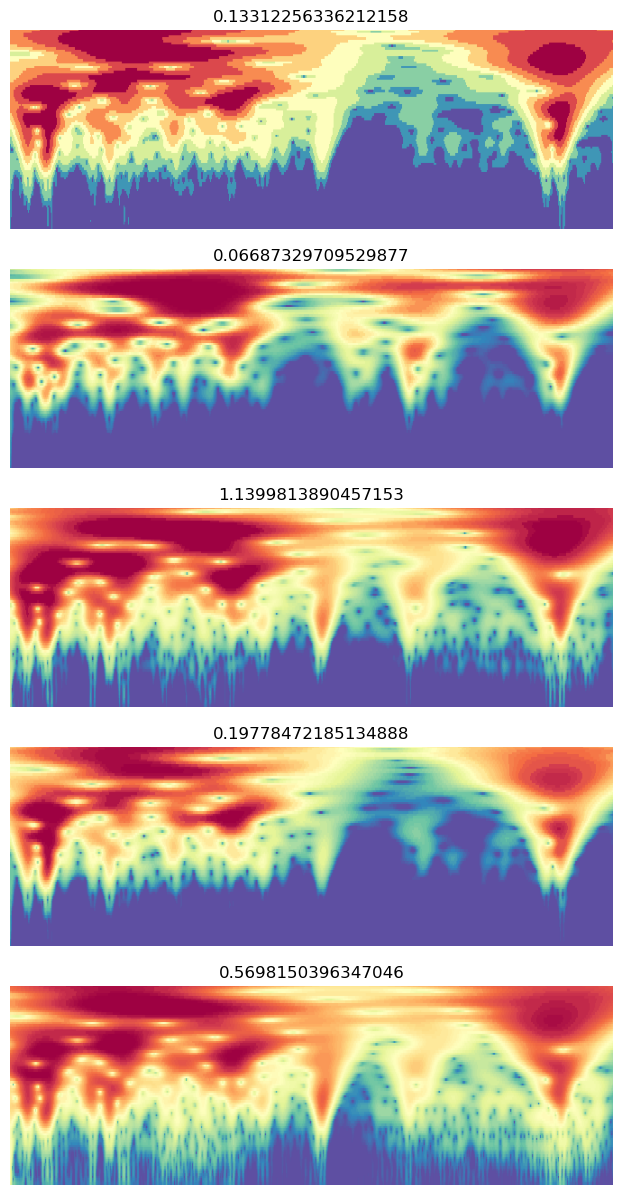

In [ ]:
dls.show_batch(nrows=5, ncols=1, figsize=(10, 15))

In [ ]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score()).to_fp16()


In [ ]:
learn = load_learner ('./models/bw-data-augment-0.pkl', cpu=True)

In [ ]:

learn.lr_find()

SuggestedLRs(valley=0.002511886414140463)

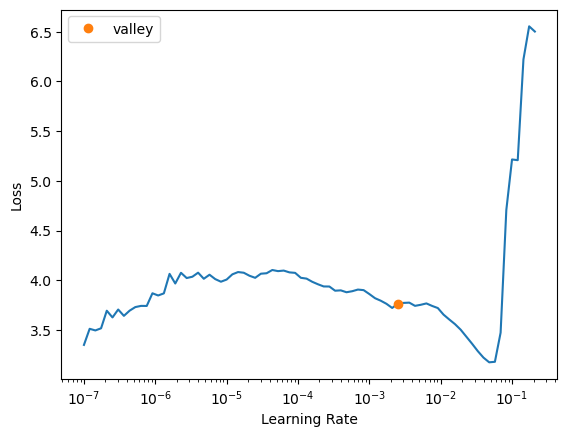

In [ ]:
learn.lr_find()

In [ ]:
# learn.fit_one_cycle(5, 3e-3)

## Evaluation

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)


In [ ]:
val_preds_tta, val_targets_tta = learn.tta(dl=dls.valid)

In [ ]:
# EXAMPLE of TTA on single item
# from fastai.vision.all import *

# # Define your TTA transforms
# tta_tfms = [
#     RandomResizedCrop(224, min_scale=0.5),
#     Flip(),
#     Rotate(degrees=(-15, 15)),
#     Brightness(max_lighting=0.2),
#     Contrast(max_lighting=0.2)
# ]

# # Create a pipeline of TTA transformations
# tta_pipeline = Pipeline(tta_tfms)

# # Load your model
# learn = load_learner('path/to/your/model.pkl')

# # Define the input data (e.g., an image)
# input_data = PILImage.create('path/to/your/image.jpg')

# # Apply TTA transforms to the input data and make predictions
# predictions = []
# for _ in range(5):  # Apply 5 different augmentations
#     augmented_data = tta_pipeline(input_data)
#     prediction = learn.predict(augmented_data)
#     predictions.append(prediction)

# # Average the predictions
# average_prediction = sum(predictions) / len(predictions)

# print(average_prediction)

In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
# Convert predictions and targets to numpy arrays
def assess_model(val_preds, val_targets):
    val_preds = val_preds.numpy().flatten()
    val_targets = val_targets.numpy()

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Predicted': val_preds,
        'Actual': val_targets
    })

    # Display the first few rows of the results
    print(results_df.head())

    # Calculate and print the R2 score
    from sklearn.metrics import r2_score
    r2 = r2_score(val_targets, val_preds)
    print(f"R2 Score on validation set: {r2:.4f}")

In [ ]:
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.312483  0.000000
1   0.126990  0.184960
2   0.365726  0.194201
3   0.239089  0.262364
4   0.402980  0.355799
R2 Score on validation set: 0.8325


In [ ]:
assess_model(val_preds_tta, val_targets_tta)

   Predicted    Actual
0   0.246857  0.000000
1   0.148590  0.184960
2   0.371643  0.194201
3   0.226535  0.262364
4   0.407333  0.355799
R2 Score on validation set: 0.8378


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.366814  0.00000
1   0.135405  0.20317
2   0.441560  0.21434
3   0.270092  0.30000
4   0.496277  0.42732
R2 Score on validation set (after transformation): 0.6936
Mean Absolute Percentage Error (MAPE) on validation set: 50.72%
Mean Absolute Error (MAE) on validation set: 0.1956


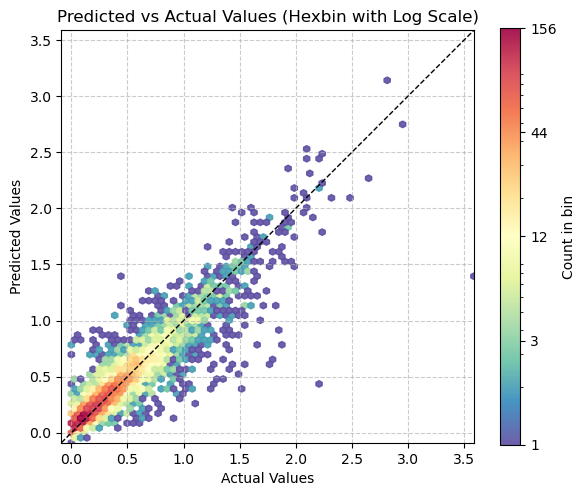

Min non-zero count in hexbins: 1.0
Max count in hexbins: 157.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379


In [ ]:
np.exp(3) - 1

19.085536923187668

## Experiments:


Color scale: `viridis` | Discretization: `percentiles = [i for i in range(60, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks |
|-----------|------------|----------------|--------|----------|----------------|------------|----------------|
| ResNet-18 | 100        | 1e-3           | 10     | 0.648    | 05:12          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     | 0.69     | 07:30          | No        | Yes             |
| ResNet-18 | 750 (original size)        |    1e-3        | 10     | 0.71          | 36:00          | No         | Yes             |
| ResNet-18 | 224        | 2e-3           | 20     |   0.704   | 07:30          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     |   0.71   | 07:00          | No        | No             |
    

Discretization: `percentiles = [i for i in range(20, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | No              | `viridis`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.71      | 05:12          | No         | No              | `jet`        |

From now on `with axis ticks` is always `No`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.71      | 05:12          | No         | None              | `jet`    |
| ResNet-18 | 224        | 2e-3         | 10     | 0.685      | 05:12          | No         | y range added              | `jet`    |


From now on random splitter with `10%` validation and random seed `41`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | Pre-train & normalize: True              | `jet`    |
| ResNet-18 | 224        | 2e-3          | 10     | 0.796     | 08:12          | No         | No Pre-train              | `jet`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.7     | 05:12          | No         | Pre-train & normalize: False            | `jet`    |
| ResNet-18 (id=0)| 224        | 2e-3          | 20     | **0.829**     | 08:12          | No         | No Pre-train (try 18 epochs)              | `jet`    |
